In [93]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize

import re
from pycountry import languages
from langdetect import DetectorFactory, detect_langs, detect
DetectorFactory.seed = 0

import spacy
nlp = spacy.load("en_core_web_sm", disable= ['tagger', 'parser', 'ner'])
from nltk.corpus import stopwords

from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, preprocess_string, strip_short

from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import LsiModel

import warnings
warnings.filterwarnings('ignore', category= UserWarning)

In [3]:
data = pd.read_csv("data/all_songs_data.csv", nrows= 10000)

### Language Detection

In [4]:
df_lang = pd.DataFrame(columns = ["en"])
for ii in data.index:
    try:
        # save probabilities
        for lang in detect_langs(data.loc[ii,"Lyrics"]):
            df_lang.loc[ii, lang.lang] = lang.prob
    except:
        pass

# add to main data frame
data['lang'] = df_lang.idxmax(axis= 1)
    

#### Top 5 Languages

In [5]:
print(data['lang'].value_counts(normalize= True).sort_values(ascending = False).head(5))

lang
en    0.976504
ro    0.006109
es    0.005796
pt    0.001723
de    0.001566
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Percentage of Billboard USA Top 100 Songs\n(in 5 Most Common Languages)')

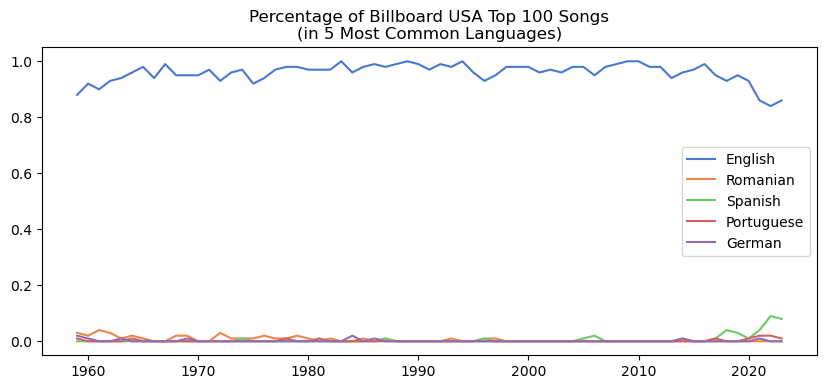

In [6]:
top_5_langs= ['en','ro','es','pt','de']
color_map = sns.color_palette('muted')

fig = plt.figure(figsize= (10,4))
dt_frac_lang= pd.pivot_table(data, index= "Year", columns= "lang", values= "Song Title", 
                        aggfunc= "count")[top_5_langs].fillna(0)/100
for ll,cc in zip(top_5_langs, color_map[:5]):
    plt.plot(dt_frac_lang[ll], color=cc, label = languages.get(alpha_2= ll).name)
plt.legend()
plt.title("Percentage of Billboard USA Top 100 Songs\n(in 5 Most Common Languages)")
# fig.savefig("images/top_5_lang_trend.png")

#### Mis-classification in Languages

The 1959 Fleetwoods song *'Come Softly To Me'* is classified as 71% portugese, 14.2% Somali and only 14% as English. This is because of notes like *Dooby doo dum dum* which our language detection algorithm identifies to be Portugese.

This is an issue to be tackled at a later stage. However, since the song contains very few English words, for now we can proceed as is.

In [7]:
def check_incorrect_language(ss, delimiter= "\n"):
    print(detect_langs(ss))
    print("----\n First 10 lines of song:\n")
    print("\n".join(re.split(delimiter, ss)[:10]))

check_incorrect_language(data.loc[7, "Lyrics"], delimiter= ', dum doo ')

[pt:0.7142843296228, en:0.14285760664171937, so:0.1428566298679429]
----
 First 10 lines of song:

Doo dooby doo Dum dum
dum, dooby doo Dum dum
dum, dooby doo Dum dum
dum, dooby doo Dum dum
dum, dooby doo  (Come softly, darling) Dum dum
dum, dooby doo (Come softly, darling) Dum dum
dum, dooby doo (Come softly, darling) Dum dum
dum, dooby doo (Come softly, darling) Dum dum
dum, dooby doo  (Come softly, darling) Dum dum
dum, dooby doo (Come to me, stay) Dum dum


Similarly, the 1963 Elvis Presley song *'(You're The) Devil In Disguise'* is classfied as 57% English and 43% Afrikaans.

In [8]:
check_incorrect_language(data.loc[468, "Lyrics"], "l |  ")

[en:0.5714272063218119, af:0.42857121085653394]
----
 First 10 lines of song:

You look like an ange
Walk like an ange
Talk like an ange
But I got wise You're the devi
in disguise Oh yes you are The devi
in disguise
You fooled me with your kisses You cheated and you schemed Heaven knows how you lied to me You're not the way you seemed
You look like an ange
Walk like an ange
Talk like an ange


### Length of Songs

In [9]:
data['length'] = winsorize(data['Lyrics'].apply(lambda x: len(x.split(" ")) if isinstance(x, str) else 0), (0.01, 0.01))

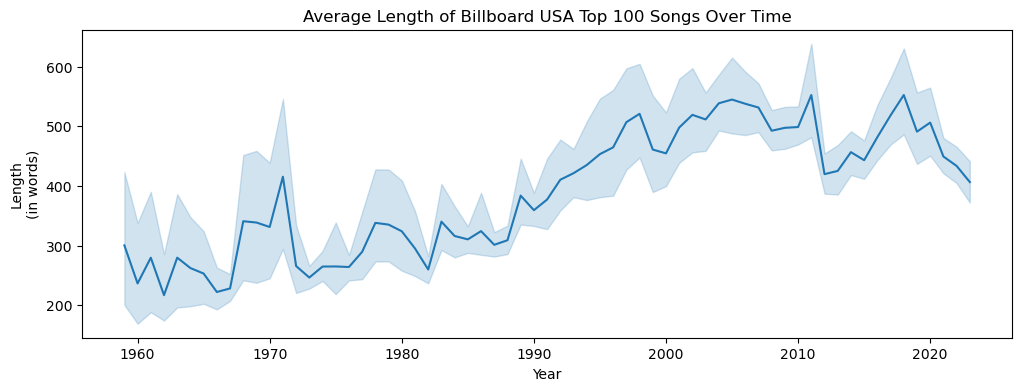

In [10]:
fig = plt.figure(figsize= (12,4))
sns.lineplot(data= data, x= "Year", y= "length")
plt.title("Average Length of Billboard USA Top 100 Songs Over Time");
plt.ylabel("Length\n(in words)");
# fig.savefig("images/song_length_over_time.png")

### Preprocessing using gensim

In [104]:
def remove_punctuation(text):
    # remove punctuation
    reg_punc =re.compile(r'[^\w\s]')
    text = reg_punc.sub(r'', text)
    return text

def remove_html_url(text):

    # remove html
    reg_html = re.compile(r'<.*?>')
    text = reg_html.sub(r'', text)
    # remove url
    reg_url = re.compile(r'http\S+')
    text = reg_url.sub(r'', text)

    return text

def remove_numbers(text):
    # remove numerical values
    reg_num = re.compile(r'[0-9]')
    text = reg_num.sub(r'', text)
    return text

def remove_special_char(text):
    # remove special characters
    reg_spcl = re.compile('[@_!#$%^&*()<>?/\\|}{~:]')
    text = reg_spcl.sub(r'', text)
    return text

def remove_emoji(text):
    # remove emoji
    emoji_url = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_url.sub(r'', text)

    return text

# preprocess given text
def preprocess(text):
    
    # clean text based on given filters
    CUSTOM_FILTERS = [lambda x: x.lower(), remove_stopwords, remove_punctuation, remove_emoji,
                                remove_html_url, remove_numbers, remove_special_char]
    text = preprocess_string(text, CUSTOM_FILTERS)
    text = " ".join(text)
    
    return text

# lemmatize text using spacy
def lemmatize_text(text):
    return [" ".join([token.lemma_ for token in doc]) for doc in tqdm(nlp.pipe(text, batch_size=32)) ]

stop_words = [remove_punctuation(ww) for ww in stopwords.words('english')]

In [12]:
data['clean_lyrics'] = data['Lyrics'].fillna('').apply(preprocess)
data['clean_lyrics'] = lemmatize_text(data['clean_lyrics'])
data['clean_length'] = winsorize(data['clean_lyrics'].apply(lambda x: len(x.split(" ")) if isinstance(x, str) else 0), (0.01, 0.01))

6500it [02:01, 53.35it/s] 


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [105]:
tfidf = TfidfVectorizer(min_df= 0.1, max_df= 0.5, stop_words= stop_words)
dt_tfidf = tfidf.fit_transform(data.query("lang== 'en' and Year <=1980")['clean_lyrics'])

len(tfidf.vocabulary_)

66

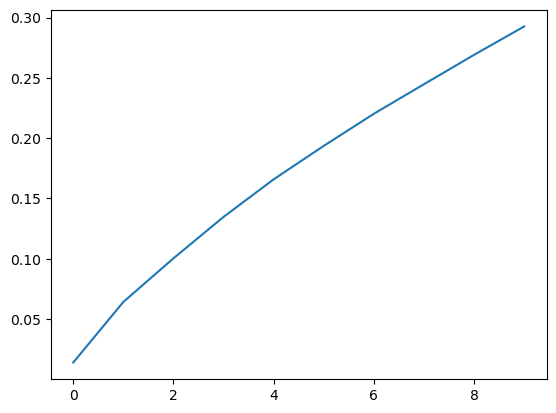

In [106]:
svd = TruncatedSVD(n_components= 10).fit(dt_tfidf)
plt.plot(svd.explained_variance_ratio_.cumsum())

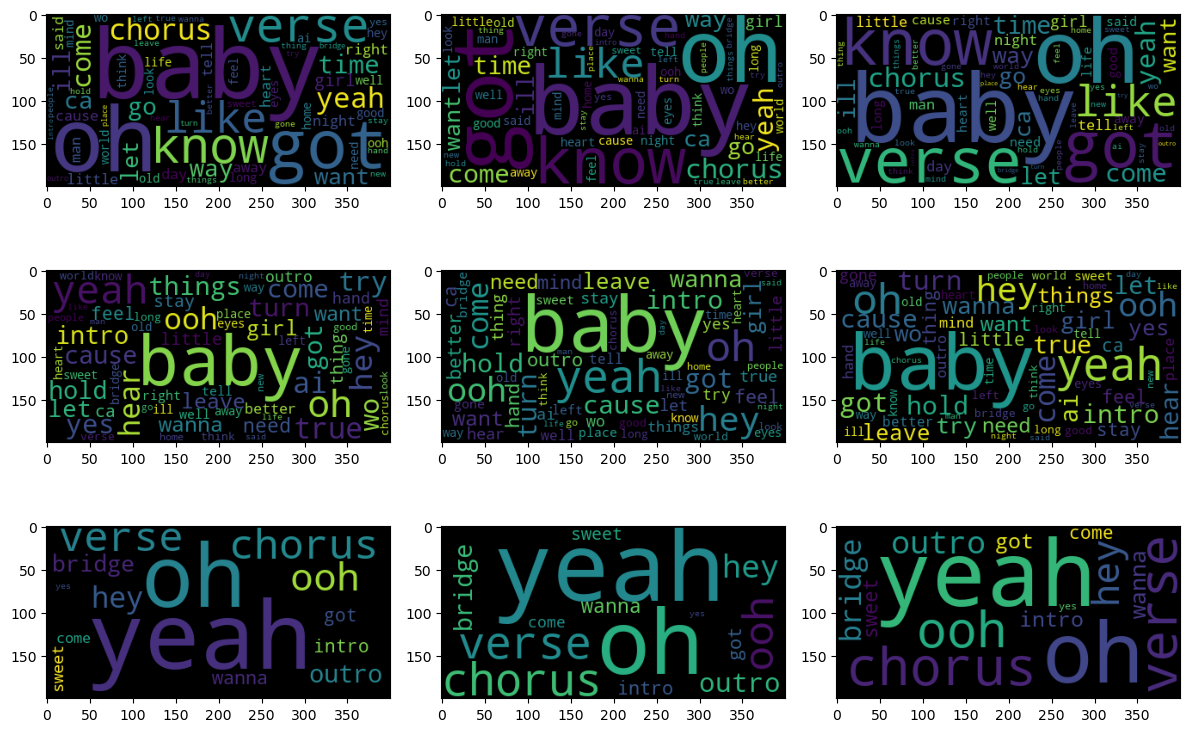

In [108]:
from wordcloud import WordCloud


fig,axs = plt.subplots(figsize= (12,8), ncols= 3, nrows= 3)

ii = 0; jj= 0;
for nn in range(0, min(9,svd.n_components)):
    fig = WordCloud().generate_from_frequencies(frequencies=pd.DataFrame(svd.components_, 
                                    columns= tfidf.get_feature_names_out()).loc[ii].to_dict())
    axs[ii,jj].imshow(fig)

    if jj == 2:
        jj = 0
        ii += 1
    else:
        jj += 1

plt.tight_layout()

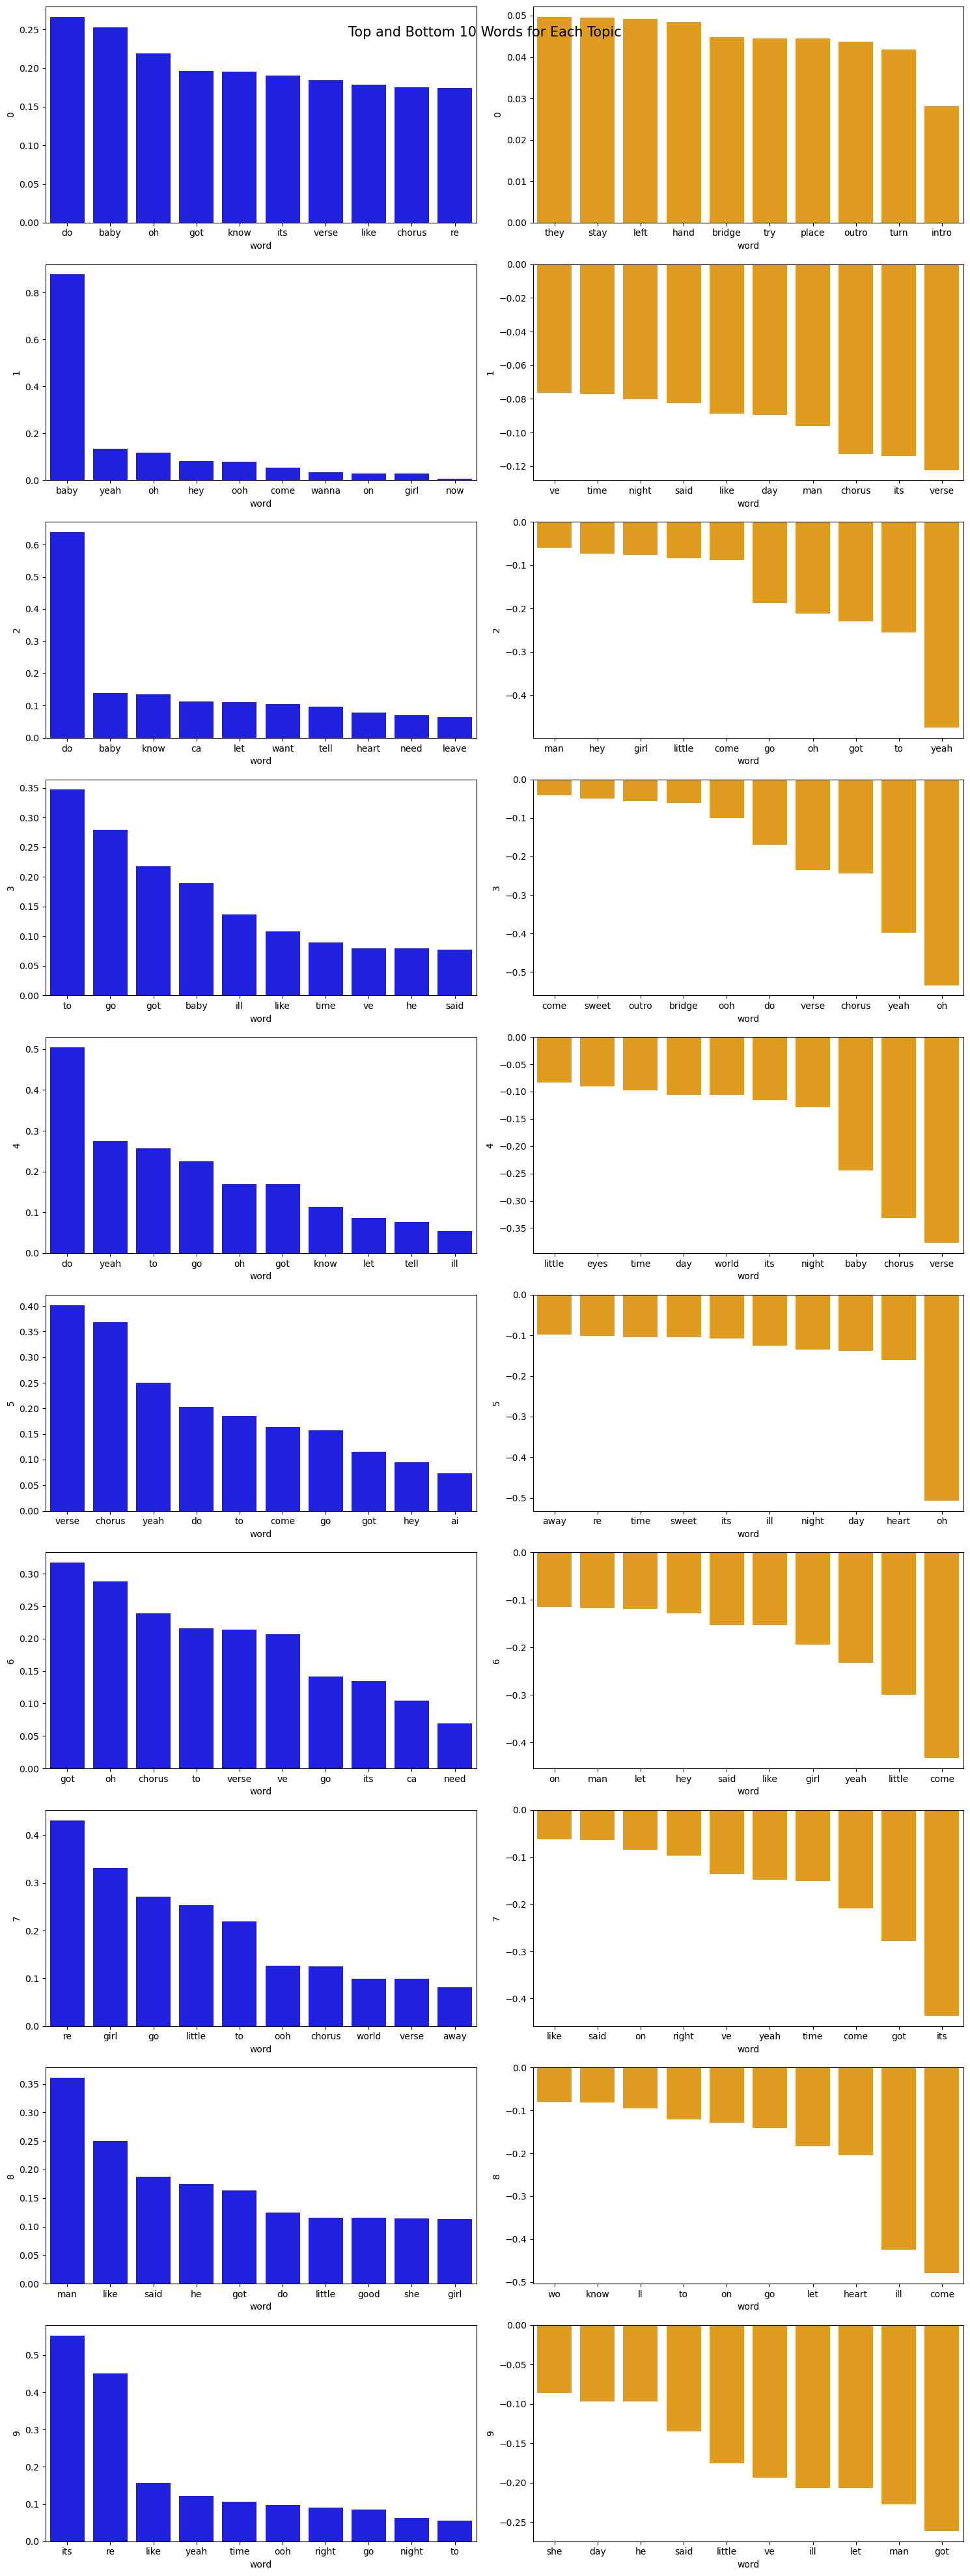

In [92]:
lsi = LsiModel(dt_tfidf.T, num_topics= 10, id2word= {value:key for key,value in tfidf.vocabulary_.items()})

res = pd.DataFrame(lsi.get_topics(), columns= tfidf.get_feature_names_out()).T
# res.columns = ['Topic_'+str(cc) for cc in res.columns]
res.index.name= "word"
res.reset_index(inplace= True)

fig, axs = plt.subplots(figsize= (15,4*lsi.num_topics), ncols= 2, nrows= lsi.num_topics)

for n_t in range(0,lsi.num_topics):

    res.sort_values(n_t, inplace= True, ascending= False)
    sns.barplot(res.head(10), x= "word", y= n_t, color= "blue", ax= axs[n_t,0])
    sns.barplot(res.tail(10), x= "word", y= n_t, color= "orange", ax= axs[n_t,1])

plt.suptitle("Top and Bottom 10 Words for Each Topic", fontsize= 15)
plt.tight_layout()

# res.loc[n_t].sort_values(ascending = False).head(10).plot(kind= 'bar')
# plt.figure()
# res.loc[n_t].sort_values(ascending = False).tail(10).plot(kind= 'bar', color= 'orange')
# # lsi.show_topics(num_words= 10, formatted= False)